<a href="https://colab.research.google.com/github/kmswin1/Pytorch-Study/blob/master/CycleGAN_with_Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Colab 에서 Pytorch 세팅

In [0]:
import os
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
accelerator = 'cu80' if os.path.exists('/opt/bin/nvidia-smi') else 'cpu'
!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision

tcmalloc: large alloc 1073750016 bytes == 0x5c74e000 @  0x7f6b728491c4 0x46d6a4 0x5fcbcc 0x4c494d 0x54f3c4 0x553aaf 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54e4c8


구글 드라이브 연동

!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

!mkdir -p drive
!google-drive-ocamlfuse drive
!mkdir data
!cp -r ./drive/"colab data" ./data
!ls data

라이브러리 로드

In [0]:
import os
import sys
import timeit
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import scipy as sp
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline

#plt.rc('text', usetex = True)
mpl.rcParams["font.family"] = "serif"
mpl.rcParams["font.size"] = "15"

print('python version : ', sys.version)
print('numpy version : ', np.version.version)
print('scipy version : ', sp.__version__)
print('matplotlib version :', mpl.__version__)
print('pytorch version : ', torch.__version__)
print('Cuda : ', torch.cuda.is_available())

python version :  3.6.3 (default, Oct  3 2017, 21:45:48) 
[GCC 7.2.0]
numpy version :  1.14.5
scipy version :  0.19.1
matplotlib version : 2.1.2
pytorch version :  0.4.0
Cuda :  True


Hyperparameter 지정

In [0]:
batchSize = 128
learningRate = 0.0002
epochNum = 30
inputDim = 28 * 28
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Cifar-10 / Cifar-100 데이터

In [0]:
dataTrainDIGIT = torchvision.datasets.MNIST(root = './data/mnist',
                                         train = True,
                                         download = True,
                                         transform = transforms.Compose([
                                                        transforms.CenterCrop(28),
                                                        transforms.ToTensor()]))

dataTestDIGIT = torchvision.datasets.MNIST(root = './data/mnist',
                                         train = False,
                                         download = True,
                                         transform = transforms.Compose([
                                                        transforms.CenterCrop(28),
                                                        transforms.ToTensor()]))

trainLoaderDIGIT = torch.utils.data.DataLoader(dataset = dataTrainDIGIT, 
                                         batch_size = batchSize, 
                                         shuffle = True)

testLoaderDIGIT = torch.utils.data.DataLoader(dataset = dataTestDIGIT, 
                                         batch_size = batchSize, 
                                         shuffle = False)

dataTrainFASHION = torchvision.datasets.FashionMNIST(root = './data/fashion',
                                                    train = True,
                                                    download = True,
                                                    transform = transforms.Compose([
                                                                            transforms.CenterCrop(28),
                                                                            transforms.ToTensor()]))

dataTestFASHION = torchvision.datasets.FashionMNIST(root = './data/fashion',
                                         train = False,
                                         download = True,
                                         transform = transforms.Compose([
                                                        transforms.CenterCrop(28),
                                                        transforms.ToTensor()]))

trainLoaderFASHION = torch.utils.data.DataLoader(dataset = dataTrainFASHION, 
                                         batch_size = batchSize, 
                                         shuffle = True)

testLoaderFASHION = torch.utils.data.DataLoader(dataset = dataTestFASHION, 
                                         batch_size = batchSize, 
                                         shuffle = False)

classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')
classes_fashion = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle_boot')

Processing...
Done!
Processing...
Done!


데이터 미리보기

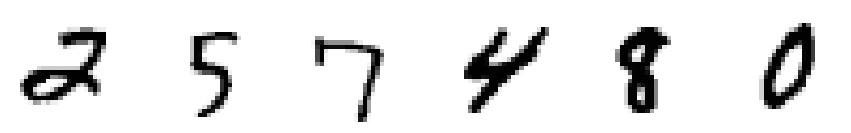

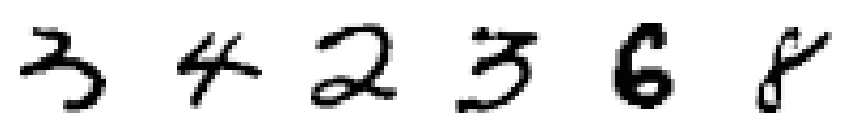

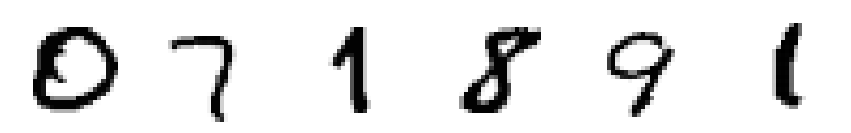

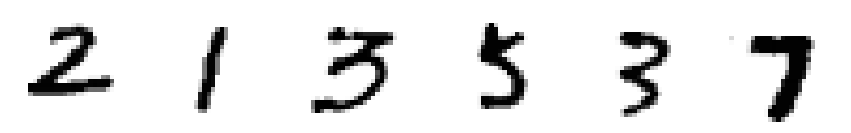

In [0]:
def show_images(image, n_row):
  
  for _ in range(n_row):  
  
    index=np.random.choice(100, 6) # 0 ~ 99의 정수 중  6개 랜덤 샘플링
    images =image.numpy()[index] # 랜덤 샘플링 된 index에 해당하는 이미지 변수 저장
    
    plt.figure(figsize=(15,90)) # 세로 사이즈 15, 가로 사이즈 15*6
    
    for a in range(161, 167):    
    
      plt.subplot(a)
      plt.imshow(images[a-161])
      plt.xticks([])
      plt.yticks([])    
    
    plt.show()  

for i, (image,_) in enumerate(trainLoaderDIGIT): 
  
  show_images(image.squeeze(), 4)
  break

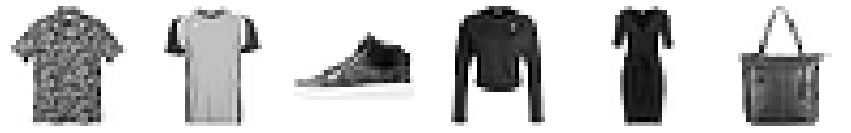

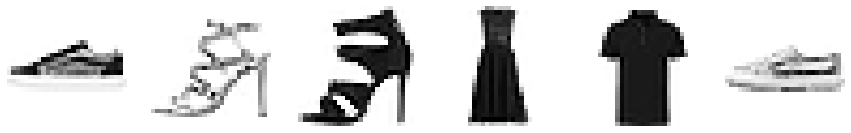

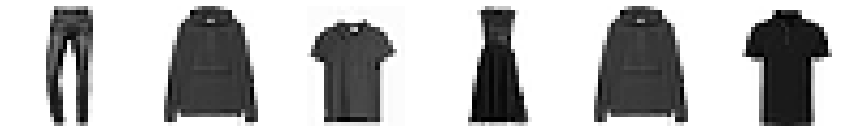

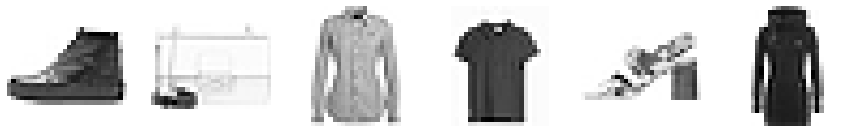

In [0]:
for i, (image,_) in enumerate(trainLoaderFASHION): 
  
  show_images(image.squeeze(), 4)
  break

모델 구현

In [0]:
class G(nn.Module):
  
  def __init__(self, ):
    
    super(G, self).__init__()

    self.conv1 = nn.Conv2d(1, 4, 3, stride = 1, padding = 1)
    self.conv2 = nn.Conv2d(4, 16, 3, stride = 1, padding = 1)
    self.conv3 = nn.Conv2d(16, 32, 3, stride = 1, padding = 1)
    self.conv4 = nn.Conv2d(32, 64, 3, stride = 1, padding = 1)
    self.conv5 = nn.Conv2d(64, 256, 3, stride = 1, padding = 1)
    self.conv6 = nn.Conv2d(256, 512, 3, stride = 1, padding = 1)
    self.conv7 = nn.Conv2d(512, 256, 3, stride = 1, padding = 1)
    self.conv8 = nn.Conv2d(128, 32, 3, stride = 1, padding = 1)
    self.conv9 = nn.Conv2d(32, 4, 3, stride = 1, padding = 1)
    self.conv10 = nn.Conv2d(4, 1, 1, stride = 1, padding = 1)

    self.deconv1 = nn.ConvTranspose2d(256, 64, 3, stride = 2, padding = 1, output_padding = 1)
    self.deconv2 = nn.ConvTranspose2d(32, 16, 3, stride = 2, padding = 1, output_padding = 1)
    
  def forward(self, x):

    # (?, 4, 28, 28)
    out1 = F.relu(self.conv1(x.to(device)), inplace = True)
    # (?, 16, 28, 28)
    out2 = F.relu(self.conv2(out1), inplace = True)
    
    # (?, 32, 14, 14)
    out3 = F.relu(self.conv3(F.max_pool2d(out2, 2)), inplace = True)
    # (?, 64, 14, 14)
    out4 = F.relu(self.conv4(out3), inplace = True)
    
    # (?, 256, 7, 7)
    out5 = F.relu(self.conv5(F.max_pool2d(out4, 2)), inplace = True)
    # (?, 512, 7, 7)
    out6 = F.relu(self.conv6(out5))
    # (?, 256, 7, 7)
    out7 = F.relu(self.conv7(out6))
    
    # out4.shape     (?, 64, 14, 14) out8.shape    (?, 64, 14, 14)    -> torch.cat((out4, out8), 1)      (?, 128, 14, 14)
    
    # (?, 64, 14, 14)
    out8 = F.relu(self.deconv1(out7), inplace = True)
    # (?, 32, 14, 14)
    out9 = F.relu(self.conv8(torch.cat((out4, out8), 1)), inplace = True)
    
    # (?, 16, 28, 28)
    out10 = F.relu(self.deconv2(out9), inplace = True)
    # (?, 4, 28, 28)
    out11 = F.relu(self.conv9(torch.cat((out2, out10), 1)), inplace = True)
    
    # (?, 1, 28, 28)
    out = F.relu(self.conv10(out11), inplace = True)
    
    return out
  
class D(nn.Module):
  
  def __init__(self):
    
    super(D, self).__init__()
    
    self.conv1 = nn.Conv2d(1, 32, 3, stride = 2, padding = 1)
    self.conv2 = nn.Conv2d(32, 128, 3, stride = 2, padding = 1)
    self.fc = nn.Linear(7 * 7 * 128, 1)
    
  def forward(self, x):
    
    out = F.relu(self.conv1(x.to(device)), inplace = True)
    out = F.relu(self.conv2(out), inplace = True)
    out = out.view(batchSize, -1)
    out = F.sigmoid(self.fc(out))
    
    return out

G_df = G().train()
G_fd = G().train()
D_d = D().train()
D_f = D().train()
  
G_df = G().to(device)
G_fd = G().to(device)
D_d = D().to(device)
D_f = D().to(device)

In [0]:
digit_iter = iter(trainLoaderDIGIT)
fashion_iter = iter(trainLoaderFASHION)

print('iterNum : ', min(len(digit_iter), len(fashion_iter)))

iterNum :  469


학습

In [0]:
G_optimizer = torch.optim.Adam(list(G_df.parameters()) + list(G_fd.parameters()), lr = learningRate)
D_optimizer = torch.optim.Adam(list(D_d.parameters()) + list(D_f.parameters()), lr = learningRate)

for epoch in range(epochNum):
 
  digit_iter = iter(trainLoaderDIGIT)
  fashion_iter = iter(trainLoaderFASHION)

  for idx in range(min(len(digit_iter), len(fashion_iter))):

    try:
      
      mnist, _ = digit_iter.next()
      fashion, _ = fashion_iter.next()

      fakeFashion = G_df(mnist)
      fakeDIGIT = G_fd(fashion)

      # loss from real data
      D_optimizer.zero_grad()
      D_loss = torch.mean((D_d(mnist) - 1) ** 2) + torch.mean((D_f(fashion) - 1) ** 2)
      D_loss.backward()
      D_optimizer.step()
      # loss from fake data
      D_optimizer.zero_grad()
      D_loss = torch.mean(D_d(fakeDIGIT) ** 2) + torch.mean(D_f(fakeFashion) ** 2)
      D_loss.backward()
      D_optimizer.step()

      reconstDIGIT = G_fd(fakeFashion)
      reconstFashion = G_fd(fakeDIGIT)

      G_optimizer.zero_grad()
      G_loss = torch.mean((mnist - reconstDIGIT) ** 2) +  torch.mean((fashion - reconstFashion) ** 2)
      G_loss.backward()
      G_optimizer.step()

      if (idx + 1) % 200 == 0:

        print("Epoch [{}/{}], step [{}/{}], D_loss : {:.4f}, G_loss {:.4f}".format(epoch + 1, epochNum, idx + 1, min(len(digit_iter), len(fashion_iter)), D_loss.item(), G_loss.item()))
        
    except:
      
      continue
      
  print("Epoch [{}/{}], step [{}/{}], D_loss : {:.4f}, G_loss {:.4f}".format(epoch + 1, epochNum, idx + 1, min(len(digit_iter), len(fashion_iter)), D_loss.item(), G_loss.item()))

8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


테스트